In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import joblib

import tensorflow as tf

import math

pd.set_option('display.max_rows', 10000)

%matplotlib inline
%reload_ext tensorboard

In [9]:
np.random.seed(42)
tf.random.set_seed(42)

def create_dataset(df, window_size):
    X, y = [], []
    for i in range(len(df) - window_size):
        v = df.iloc[i:(i + window_size)].values
        X.append(v)
        y.append(df["Close"].iloc[i + window_size])
    return np.array(X), np.array(y)

def create_split(df, pct_train, pct_val, batch_size, window_size):
    length = df.shape[0]
    temp_train_size = find_batch_gcd(math.floor(pct_train * length), batch_size)
    test_size = length - temp_train_size
    train_size = find_batch_gcd(math.floor((1 - pct_val) * temp_train_size), batch_size)
    val_size = temp_train_size - train_size
    df_train = df[:- val_size - test_size]
    df_val = df[- val_size - test_size - window_size:- test_size]
    df_test = df[- test_size - window_size:]
    return df_train, df_val, df_test

def find_batch_gcd(length, batch_size):
    while length % batch_size != 0:
        length -= 1
    return length

def flatten_prediction(pred, pred_count, time_steps):
    print(pred_count, pred.shape[0])
    pred = pred[::time_steps]
    pred = pred.flatten()
    if pred_count < pred.shape[0]:
        pred = pred[:pred_count - pred.shape[0]]
    return pred

def evaluate_forecast(pred, actual):
    mse = mean_squared_error(pred, actual)
    print("Test Mean Squared Error:", mse)
    mae = mean_absolute_error(pred, actual)
    print("Test Mean Absolute Error:", mae)
    return None

def test_model(pair, window_size, batch_size, time_steps):
    fScaler = joblib.load("../scalers/{}/features.bin".format(pair))
    scaler = joblib.load("../scalers/{}/close.bin".format(pair))
    model = tf.keras.models.load_model("../models/{}".format(pair))
    
    buy = pair[:3]
    sell = pair[3:]

    series = pd.read_csv("../data/processed/{}_processed.csv".format(pair))
    series = series[series.shape[0] % batch_size:]
    close = series[['Time', 'Real Close', 'Close']]
    close = close.copy()

    series = series.drop(['Time', 'Real Close'], axis=1)
    series = series[['Close', 'EMA_10', 'EMA_50', 'RSI', 'A/D Index',
                     '{} Interest Rate'.format(buy), '{} Interest Rate'.format(sell), '{}_CPI'.format(buy), '{}_CPI'.format(sell),
                     '{} Twitter Sentiment'.format(buy), '{} Twitter Sentiment'.format(sell),
                     '{} News Sentiment'.format(buy), '{} News Sentiment'.format(sell),
                     #'EUR_GDP', 'USD_GDP', 'EUR Unemployment Rate', 'USD Unemployment Rate', 'EUR_PPI', 'USD_PPI'
                    ]]

    df_train, df_val, df_test = create_split(series, 0.75, 0.1, batch_size, window_size)
    print(f'df_train.shape {df_train.shape}, df_validation.shape {df_val.shape}, df_test.shape {df_test.shape}')
    df_test = df_test.copy()
    df_test.loc[:, ['Close']] = scaler.transform(df_test[['Close']])
    df_test.loc[:, ~df_test.columns.isin(['Close'])] = fScaler.transform(df_test.loc[:, ~df_test.columns.isin(['Close'])])

    X_test, y_test = create_dataset(df_test, window_size)

    y_pred = model.predict(X_test)

    multi_pred = flatten_prediction(y_pred, y_test.shape[0], time_steps)
    evaluate_forecast(multi_pred, y_test)
    
    df = pd.DataFrame(close[-multi_pred.shape[0] - window_size:])    
    df = df[window_size:]
    df.reset_index(inplace=True, drop=True)

    index = [i for i in range(multi_pred.shape[0])]
    df_predicted = pd.DataFrame(scaler.inverse_transform(multi_pred.reshape(-1, 1)), columns=['Close'], index=index)
    df_actual = pd.DataFrame(scaler.inverse_transform(y_test.reshape(-1, 1)), columns=['Close'], index=index)
    
    df['Multi'] = df_predicted
    df['Multi'] = df['Multi'].shift(1)
    
    df['Prediction'] = np.nan
    
    for i in range(1, df_predicted.shape[0]):
        if (i - 1)%time_steps == 0:
            df.loc[i, 'Prediction'] = df.loc[i-1, 'Real Close']*math.exp(df.loc[i, 'Multi'])
        else:
            df.loc[i, 'Prediction'] = df.loc[i-1, 'Prediction']*math.exp(df.loc[i, 'Multi'])
    
    df_actual = df['Real Close'].mul(np.exp(df_actual['Close'].shift(-1))).shift(1)
    print(df.shape)
    print(df)
    
    evaluate_forecast(df['Prediction'].iloc[1:], df['Real Close'].iloc[1:])

    return df['Prediction'].iloc[1:], df['Real Close'].iloc[1:]

def visualize_prediction(df_predicted, df_actual):
    fig = plt.figure(figsize=(24, 16))
    ax1 = fig.subplots(1)
    ax1.set_title('Predicted Closing Price')
    ax1.set(xlabel='Time', ylabel='Close')
    ax1.plot(df_actual[10000:10500], label='Actual')
    ax1.plot(df_predicted[10000:10500], label='Prediction')
    ax1.legend()

In [3]:
predicted, actual = test_model("EURUSD", 96, 64, 8)

df_train.shape (50368, 13), df_validation.shape (5728, 13), df_test.shape (18784, 13)
18688 18688
Test Mean Squared Error: 0.0008807641889815428
Test Mean Absolute Error: 0.020345848791481682
(18688, 5)
                            Time  Real Close     Close     Multi  Prediction
0      2020-04-02 02:00:00+00:00     1.09369 -0.000603       NaN         NaN
1      2020-04-02 02:15:00+00:00     1.09431  0.000567  0.000059    1.093754
2      2020-04-02 02:30:00+00:00     1.09435  0.000037  0.000051    1.093810
3      2020-04-02 02:45:00+00:00     1.09335 -0.000914  0.000037    1.093851
4      2020-04-02 03:00:00+00:00     1.09342  0.000064  0.000045    1.093900
...                          ...         ...       ...       ...         ...
18683  2020-12-31 20:45:00+00:00     1.22156  0.000000 -0.000009    1.221060
18684  2020-12-31 21:00:00+00:00     1.22151 -0.000041  0.000003    1.221064
18685  2020-12-31 21:15:00+00:00     1.22242  0.000745  0.000002    1.221066
18686  2020-12-31 21:30:00+

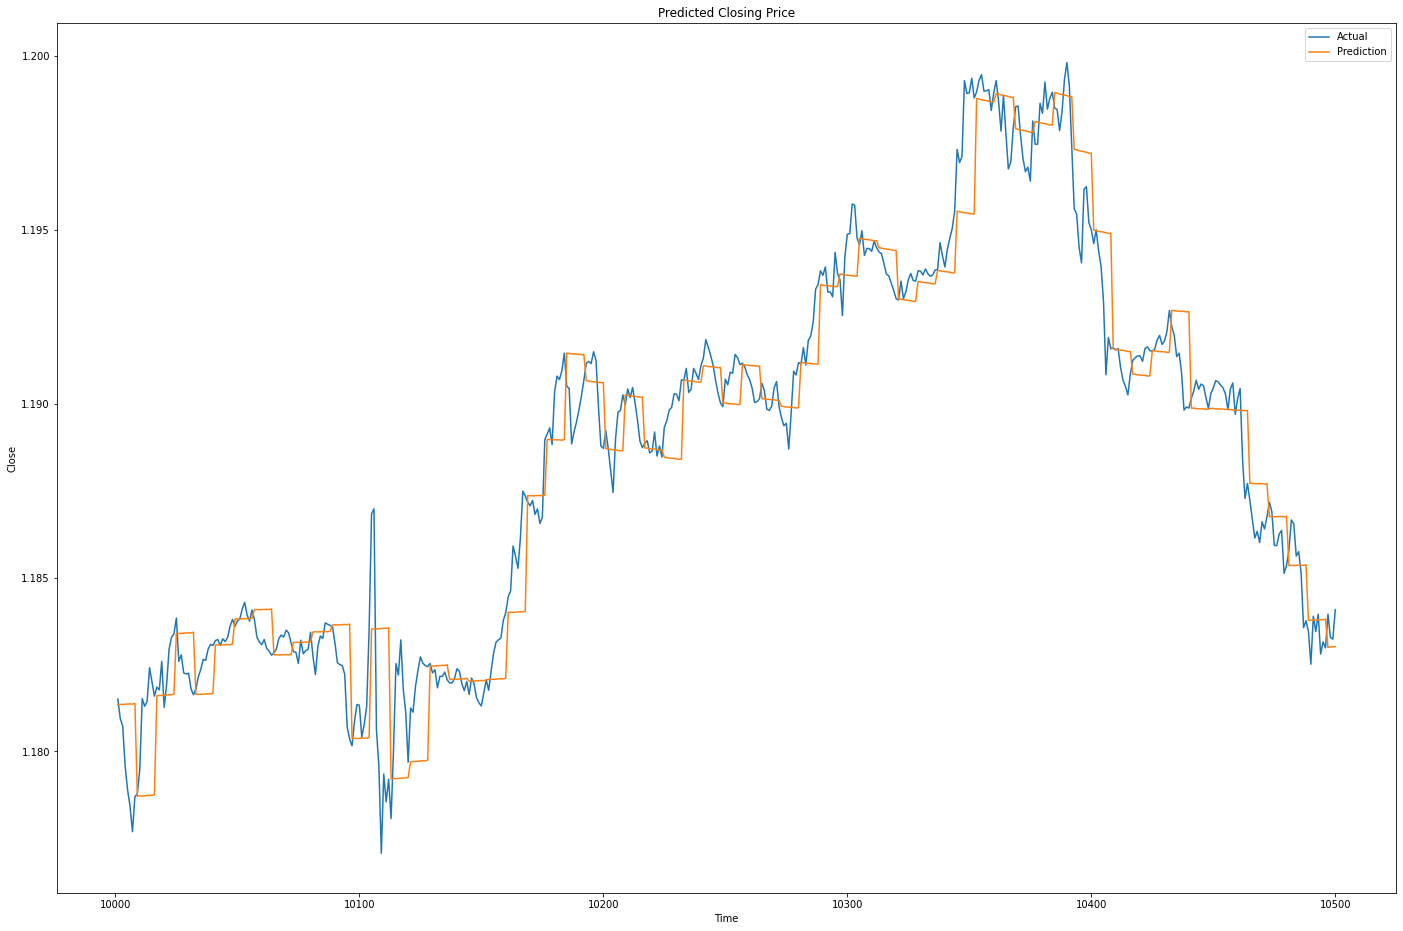

In [10]:
visualize_prediction(predicted, actual)